In [4]:
"""
MRCP ANALYSIS - MOVEMENT-RELATED CORTICAL POTENTIALS (FIXED)
=============================================================
Analysis of Bereitschaftspotential (BP) / Readiness Potential
Dataset: PhysioNet EEG Motor Movement/Imagery Dataset
Subject: S001, Run: R03 (Executed left/right fist movements)
"""

# ============================================
# IMPORTS
# ============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import mne
from mne.datasets import eegbci
from mne.channels import make_standard_montage
from scipy import signal
from scipy.stats import ttest_ind

# Suppress warnings
import warnings
warnings.filterwarnings('ignore', category=RuntimeWarning)

# Set plotting style
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 8)

print("="*70)
print("MRCP ANALYSIS - BEREITSCHAFTSPOTENTIAL")
print("="*70)
print(f"MNE version: {mne.__version__}")
print(f"Analysis: Movement-Related Cortical Potentials")
print("="*70)

# ============================================
# FILE PATHS
# ============================================
print("\n[FILE CONFIGURATION]")
print("-"*70)

EEG_FILE = r"C:\Users\fibof\Downloads\MRCP\S001R03 (1).edf"
EVENT_FILE = r"C:\Users\fibof\Downloads\MRCP\S001R03.edf (1).event"

print(f"EEG file:   {EEG_FILE}")
print(f"Event file: {EVENT_FILE}")

# Check if files exist
if not Path(EEG_FILE).exists():
    print(f"✗ EEG file not found!")
    raise FileNotFoundError(f"Cannot find: {EEG_FILE}")
else:
    print(f"✓ EEG file found")

# ============================================
# LOAD RAW EEG DATA
# ============================================
print("\n" + "="*70)
print("LOADING RAW EEG DATA")
print("="*70)

raw = mne.io.read_raw_edf(EEG_FILE, preload=True, verbose=False)

print(f"\n[RAW DATA INFORMATION]")
print(f"  Sampling frequency:  {raw.info['sfreq']} Hz")
print(f"  Duration:            {raw.times[-1]:.2f} seconds ({raw.times[-1]/60:.2f} minutes)")
print(f"  Number of channels:  {len(raw.ch_names)}")
print(f"  Total samples:       {len(raw.times)}")

print(f"\n  First 10 channel names (original):")
for i, ch in enumerate(raw.ch_names[:10]):
    print(f"    {i+1:2d}. {ch}")

# ============================================
# STANDARDIZE CHANNEL NAMES
# ============================================
print(f"\n[STANDARDIZING CHANNEL NAMES]")
eegbci.standardize(raw)
print(f"✓ Channel names standardized")
print(f"  First 10 channels: {raw.ch_names[:10]}")

# ============================================
# SET MONTAGE
# ============================================
print(f"\n[SETTING MONTAGE]")
montage = make_standard_montage('standard_1005')
raw.set_montage(montage, on_missing='warn', verbose=False)
n_matched = sum([1 for ch in raw.ch_names if ch in montage.ch_names])
print(f"✓ Montage set: standard_1005")
print(f"  Channels matched: {n_matched}/{len(raw.ch_names)}")

# ============================================
# EXTRACT EVENTS
# ============================================
print("\n" + "="*70)
print("EXTRACTING MOVEMENT EVENTS")
print("="*70)

# Extract events from annotations
events, event_id = mne.events_from_annotations(raw, verbose=False)

print(f"\n[EVENT INFORMATION]")
print(f"  Total events found: {len(events)}")
print(f"\n  Event types:")
for event_name, event_code in event_id.items():
    count = np.sum(events[:, 2] == event_code)
    print(f"    {event_name:10s} (code {event_code}): {count:3d} events")

# Create movement-specific event dictionary
movement_event_id = {}
for event_name, event_code in event_id.items():
    if 'T1' in event_name:
        movement_event_id['left_fist'] = event_code
        print(f"  ✓ Left fist:  {event_name} → code {event_code}")
    elif 'T2' in event_name:
        movement_event_id['right_fist'] = event_code
        print(f"  ✓ Right fist: {event_name} → code {event_code}")
    elif 'T0' in event_name:
        movement_event_id['rest'] = event_code
        print(f"  ✓ Rest:       {event_name} → code {event_code}")

# Count movement events
n_left = np.sum(events[:, 2] == movement_event_id.get('left_fist', -1))
n_right = np.sum(events[:, 2] == movement_event_id.get('right_fist', -1))
n_rest = np.sum(events[:, 2] == movement_event_id.get('rest', -1))

print(f"\n[EVENT COUNTS]")
print(f"  Left fist movements:  {n_left}")
print(f"  Right fist movements: {n_right}")
print(f"  Rest periods:         {n_rest}")
print(f"  Total movement trials: {n_left + n_right}")

# ============================================
# MRCP-SPECIFIC PREPROCESSING
# ============================================
print("\n" + "="*70)
print("MRCP-SPECIFIC PREPROCESSING")
print("="*70)
print("\nCRITICAL: MRCP requires preserving slow cortical potentials!")
print("Standard EEG preprocessing (1-40 Hz) would DESTROY the BP signal.")

# Configuration
MRCP_LOW_FREQ = 0.05   # Hz - preserve slow potentials
MRCP_HIGH_FREQ = 10.0  # Hz - remove high-frequency noise
NOTCH_FREQ = [60, 120] # Hz - power line noise
APPLY_CAR = True       # Common average reference

print(f"\n[PREPROCESSING PARAMETERS]")
print(f"  High-pass: {MRCP_LOW_FREQ} Hz (preserve slow potentials)")
print(f"  Low-pass:  {MRCP_HIGH_FREQ} Hz (remove muscle/noise)")
print(f"  Notch:     {NOTCH_FREQ} Hz (power line)")
print(f"  Reference: {'CAR (Common Average)' if APPLY_CAR else 'Original'}")

print(f"\n  Rationale:")
print(f"    • 0.05 Hz high-pass: Removes very slow drift but keeps BP")
print(f"    • 10 Hz low-pass: BP is in slow frequency range (<5 Hz)")
print(f"    • Avoid aggressive filtering that distorts slow waveforms")

# Create copy for MRCP processing
raw_mrcp = raw.copy()

# Step 1: Notch filter
print(f"\n[1/4] Applying notch filter...")
sfreq = raw_mrcp.info['sfreq']
nyq = sfreq / 2
valid_notch = [f for f in NOTCH_FREQ if f < nyq]

if valid_notch:
    for f in valid_notch:
        raw_mrcp.notch_filter(freqs=[f], picks='eeg', method='iir',
                              iir_params={'order': 4, 'ftype': 'butter'}, 
                              verbose=False)
    print(f"✓ Notch filter applied at {valid_notch} Hz")
else:
    print(f"⚠ No valid notch frequencies (sampling rate too low)")

# Step 2: Common average reference
if APPLY_CAR:
    print(f"\n[2/4] Setting common average reference...")
    raw_mrcp.set_eeg_reference('average', projection=False, verbose=False)
    print(f"✓ CAR applied")
else:
    print(f"\n[2/4] Skipping reference change")

# Step 3: High-pass filter (preserve slow potentials)
print(f"\n[3/4] Applying high-pass filter ({MRCP_LOW_FREQ} Hz)...")
raw_mrcp.filter(l_freq=MRCP_LOW_FREQ, h_freq=None, picks='eeg',
                method='iir', iir_params={'order': 4, 'ftype': 'butter'},
                verbose=False)
print(f"✓ High-pass filter applied")

# Step 4: Low-pass filter
print(f"\n[4/4] Applying low-pass filter ({MRCP_HIGH_FREQ} Hz)...")
raw_mrcp.filter(l_freq=None, h_freq=MRCP_HIGH_FREQ, picks='eeg',
                method='iir', iir_params={'order': 4, 'ftype': 'butter'},
                verbose=False)
print(f"✓ Low-pass filter applied")

print(f"\n✓ MRCP preprocessing complete")
print(f"  Final filter band: {MRCP_LOW_FREQ}-{MRCP_HIGH_FREQ} Hz")

# ============================================
# CHECK TARGET CHANNELS
# ============================================
print("\n" + "="*70)
print("TARGET CHANNELS FOR MRCP ANALYSIS")
print("="*70)

TARGET_CHANNELS = ['C3', 'Cz', 'C4']
available_channels = []

print(f"\nMotor cortex channels for BP analysis:")
for ch in TARGET_CHANNELS:
    if ch in raw_mrcp.ch_names:
        available_channels.append(ch)
        print(f"  ✓ {ch}: Available")
    else:
        print(f"  ✗ {ch}: Not found")

if len(available_channels) == 0:
    print(f"\n✗ ERROR: No target channels available!")
    raise ValueError("Cannot proceed without motor channels")

print(f"\n✓ Analysis will use: {available_channels}")
print(f"\nChannel roles in MRCP:")
print(f"  C3:  Left motor cortex  (contralateral to right hand)")
print(f"  Cz:  Midline motor area (bilateral representation)")
print(f"  C4:  Right motor cortex (contralateral to left hand)")

# ============================================
# CREATE MOVEMENT-LOCKED EPOCHS
# ============================================
print("\n" + "="*70)
print("CREATING MOVEMENT-LOCKED EPOCHS")
print("="*70)

# Epoch parameters for MRCP
TMIN = -3.0    # Start 3 seconds before movement
TMAX = 2.0     # End 2 seconds after movement
BASELINE = (-3.0, -2.5)  # Baseline period (early pre-movement)

print(f"\n[EPOCH PARAMETERS]")
print(f"  Time window:     {TMIN} to {TMAX} seconds relative to movement onset")
print(f"  Epoch duration:  {TMAX - TMIN} seconds")
print(f"  Baseline:        {BASELINE} seconds")
print(f"  Movement onset:  t = 0")
print(f"\n  MRCP time windows of interest:")
print(f"    Early BP:    -2.0 to -0.5 s (general preparation)")
print(f"    Late BP:     -0.5 to  0.0 s (specific execution)")
print(f"    Movement:     0.0 to +0.5 s (motor execution)")

# Select only movement events (left and right fist)
movement_events_only = {
    'left_fist': movement_event_id['left_fist'],
    'right_fist': movement_event_id['right_fist']
}

print(f"\n[CREATING EPOCHS]")
print(f"  Events to epoch: {list(movement_events_only.keys())}")

# FIXED: More lenient rejection threshold and optionally NO rejection
REJECT_THRESHOLD = 250e-6  # Increased from 150 µV to 250 µV
APPLY_REJECTION = False     # Set to False to keep all epochs

print(f"\n[ARTIFACT REJECTION SETTINGS]")
if APPLY_REJECTION:
    print(f"  Rejection enabled: YES")
    print(f"  Threshold: {REJECT_THRESHOLD * 1e6} µV")
    reject_dict = dict(eeg=REJECT_THRESHOLD)
else:
    print(f"  Rejection enabled: NO")
    print(f"  All epochs will be kept (artifacts may be present)")
    reject_dict = None

# Create epochs
epochs_mrcp = mne.Epochs(
    raw_mrcp,
    events=events,
    event_id=movement_events_only,
    tmin=TMIN,
    tmax=TMAX,
    baseline=BASELINE,
    picks='eeg',
    preload=True,
    reject=reject_dict,  # FIXED: Can be None to keep all epochs
    verbose=False
)

# Print epoch statistics
n_total = len(events[np.isin(events[:, 2], list(movement_events_only.values()))])
n_kept = len(epochs_mrcp)
n_dropped = n_total - n_kept

print(f"\n[EPOCH STATISTICS]")
print(f"  Total movement trials:  {n_total}")
print(f"  Epochs kept:            {n_kept}")
print(f"  Epochs dropped:         {n_dropped} ({100*n_dropped/n_total if n_total > 0 else 0:.1f}%)")

if n_kept > 0:
    print(f"  Left fist epochs:       {len(epochs_mrcp['left_fist'])}")
    print(f"  Right fist epochs:      {len(epochs_mrcp['right_fist'])}")
    
    if n_dropped > 0:
        print(f"\n  Rejection criterion: EEG amplitude > {REJECT_THRESHOLD * 1e6} µV")
        print(f"  Dropped epochs likely contained artifacts (blinks, movement, etc.)")
    
    print(f"\n✓ Movement-locked epochs created")
    print(f"  Shape: {epochs_mrcp.get_data().shape} (epochs × channels × timepoints)")
else:
    print(f"\n✗ WARNING: No epochs kept!")
    print(f"\n  Checking drop log...")
    drop_log = epochs_mrcp.drop_log
    reasons = {}
    for log in drop_log:
        if len(log) > 0:
            reason = str(log[0]) if len(log) > 0 else 'Unknown'
            reasons[reason] = reasons.get(reason, 0) + 1
    
    print(f"\n  Drop reasons:")
    for reason, count in reasons.items():
        print(f"    {reason}: {count} epochs")

# ============================================
# SUMMARY
# ============================================
print("\n" + "="*70)
print("DATA LOADING AND PREPROCESSING SUMMARY")
print("="*70)

print(f"\n[DATASET]")
print(f"  Subject:        S001")
print(f"  Run:            R03 (Executed fist movements)")
print(f"  Task:           Open/close left or right fist on cue")
print(f"  Duration:       {raw.times[-1]:.1f} seconds")

print(f"\n[PREPROCESSING]")
print(f"  Filter band:    {MRCP_LOW_FREQ}-{MRCP_HIGH_FREQ} Hz (MRCP-optimized)")
print(f"  Reference:      {'CAR' if APPLY_CAR else 'Original'}")
print(f"  Notch:          {valid_notch if valid_notch else 'None'} Hz")

print(f"\n[EVENTS]")
if n_kept > 0:
    print(f"  Left fist:      {len(epochs_mrcp['left_fist'])} trials")
    print(f"  Right fist:     {len(epochs_mrcp['right_fist'])} trials")
    print(f"  Total:          {len(epochs_mrcp)} movement trials")
else:
    print(f"  ✗ No epochs available for analysis")

print(f"\n[CHANNELS]")
print(f"  Motor cortex:   {available_channels}")

if n_kept > 0:
    print(f"\n[NEXT STEPS]")
    print(f"  1. Visualize averaged MRCP waveforms")
    print(f"  2. Analyze BP slope and amplitude")
    print(f"  3. Compare left vs right movements")
    print(f"  4. Extract quantitative features")
    print(f"  5. Statistical analysis")

print("\n" + "="*70)
if n_kept > 0:
    print("✓ READY FOR MRCP ANALYSIS")
else:
    print("⚠ NO EPOCHS AVAILABLE - ADJUST REJECTION SETTINGS")
print("="*70)

MRCP ANALYSIS - BEREITSCHAFTSPOTENTIAL
MNE version: 1.11.0
Analysis: Movement-Related Cortical Potentials

[FILE CONFIGURATION]
----------------------------------------------------------------------
EEG file:   C:\Users\fibof\Downloads\MRCP\S001R03 (1).edf
Event file: C:\Users\fibof\Downloads\MRCP\S001R03.edf (1).event
✓ EEG file found

LOADING RAW EEG DATA

[RAW DATA INFORMATION]
  Sampling frequency:  160.0 Hz
  Duration:            124.99 seconds (2.08 minutes)
  Number of channels:  64
  Total samples:       20000

  First 10 channel names (original):
     1. Fc5.
     2. Fc3.
     3. Fc1.
     4. Fcz.
     5. Fc2.
     6. Fc4.
     7. Fc6.
     8. C5..
     9. C3..
    10. C1..

[STANDARDIZING CHANNEL NAMES]
✓ Channel names standardized
  First 10 channels: ['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1']

[SETTING MONTAGE]
✓ Montage set: standard_1005
  Channels matched: 64/64

EXTRACTING MOVEMENT EVENTS

[EVENT INFORMATION]
  Total events found: 30

  Event ty


MRCP WAVEFORM VISUALIZATION

[CHECKING EPOCH AVAILABILITY]
----------------------------------------------------------------------
✓ Epochs available: 15 total
  Left fist:  8
  Right fist: 7

[COMPUTING AVERAGED MRCP WAVEFORMS]
----------------------------------------------------------------------
✓ Evoked responses computed
  All movements:   15 trials averaged
  Left fist:       8 trials averaged
  Right fist:      7 trials averaged

[PLOT 1: MRCP WAVEFORMS AT C3/CZ/C4]


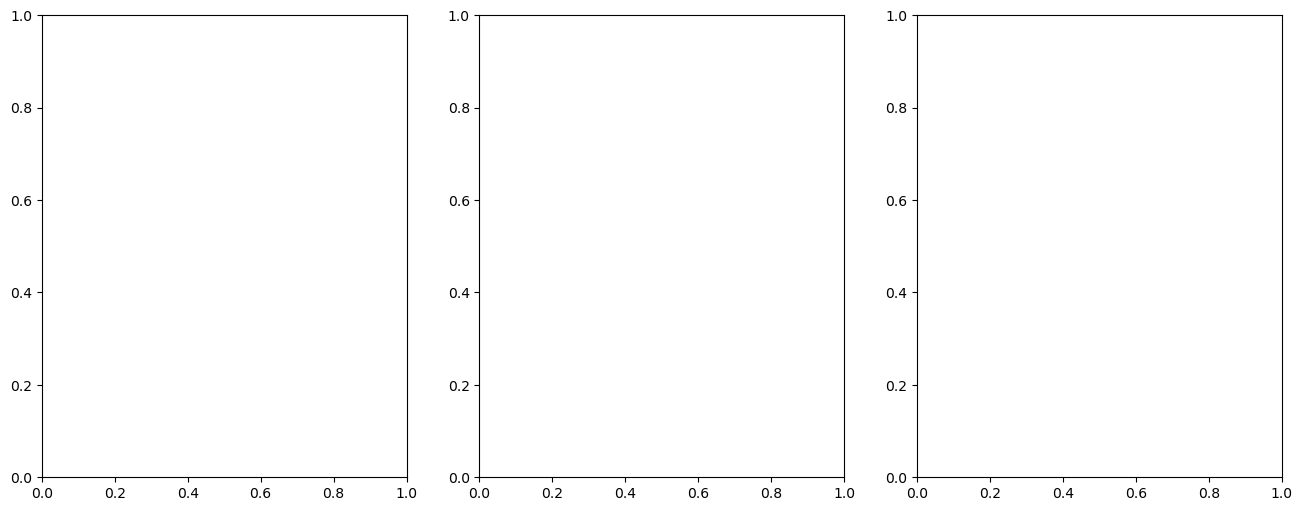

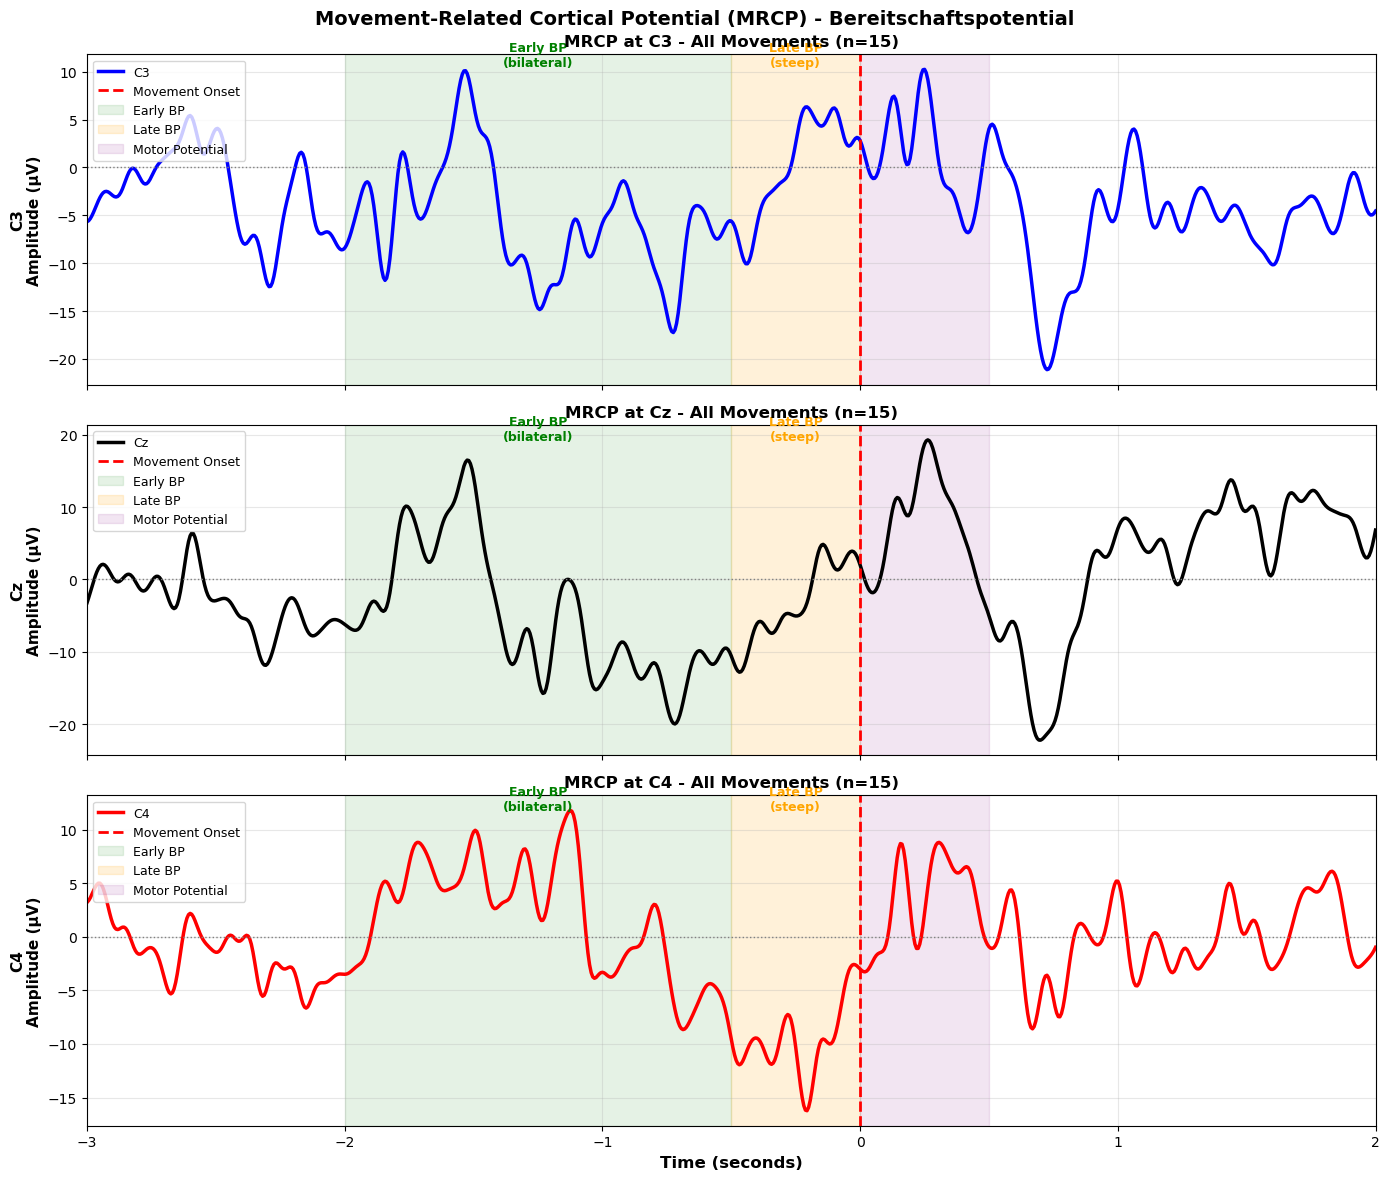

✓ MRCP waveforms plotted

[PLOT 2: LEFT VS RIGHT FIST COMPARISON]


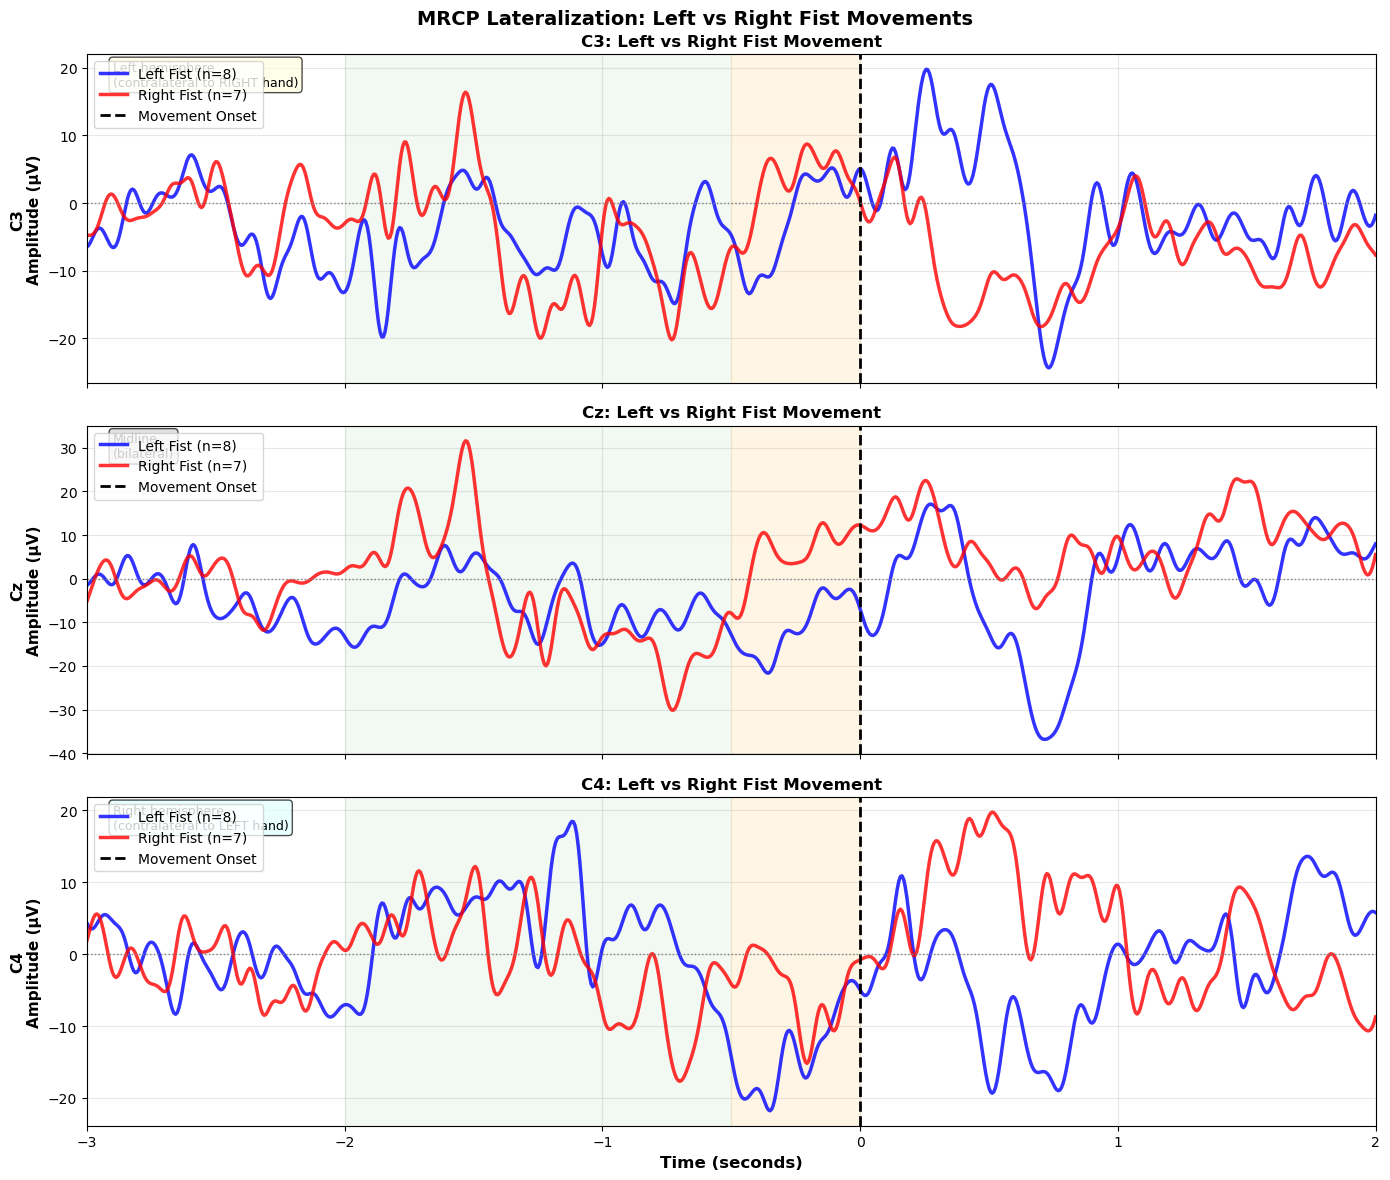

✓ Left vs Right comparison plotted

[PLOT 3: TOPOGRAPHIC MAPS]


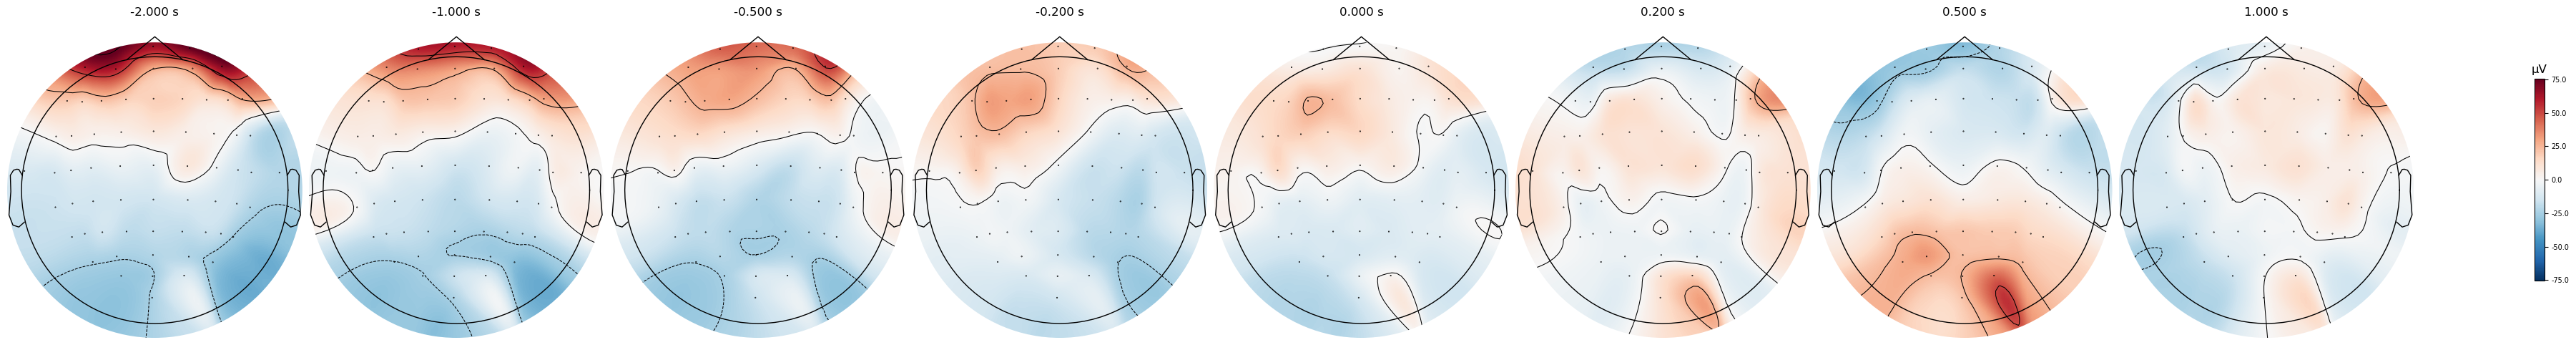

✓ Topographic maps plotted

[PLOT 4: EPOCH IMAGE PLOTS]
  Creating epoch image for C3...
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


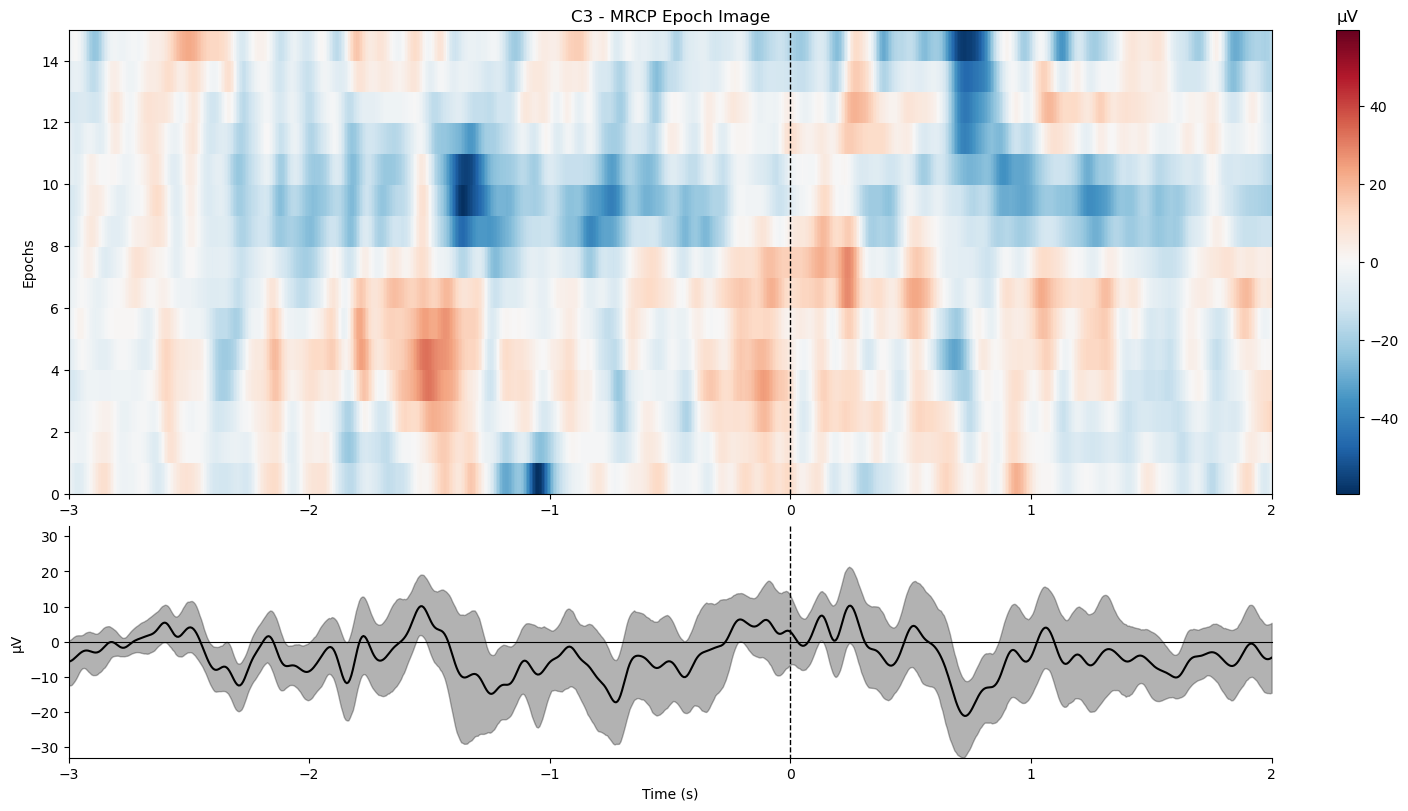

  Creating epoch image for Cz...
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


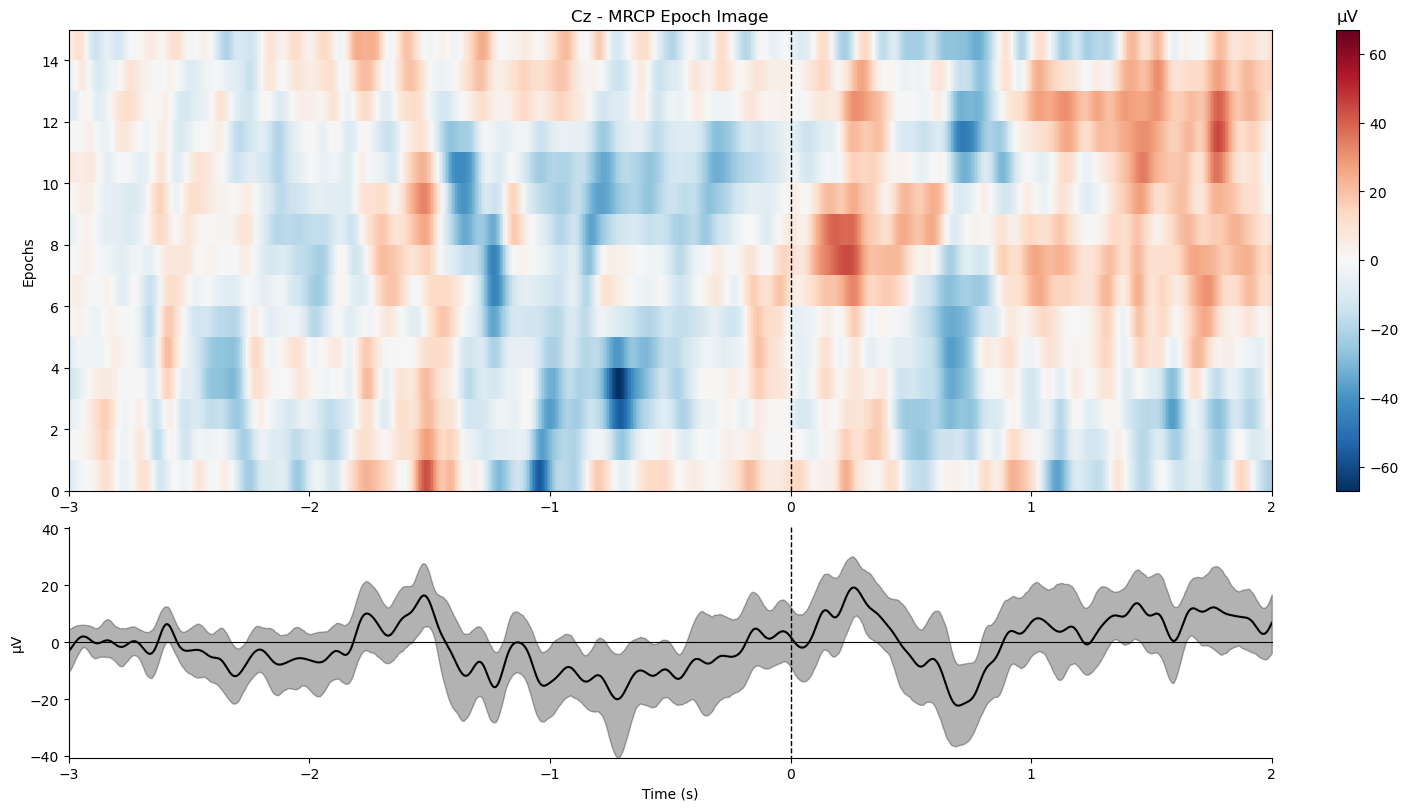

  Creating epoch image for C4...
Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


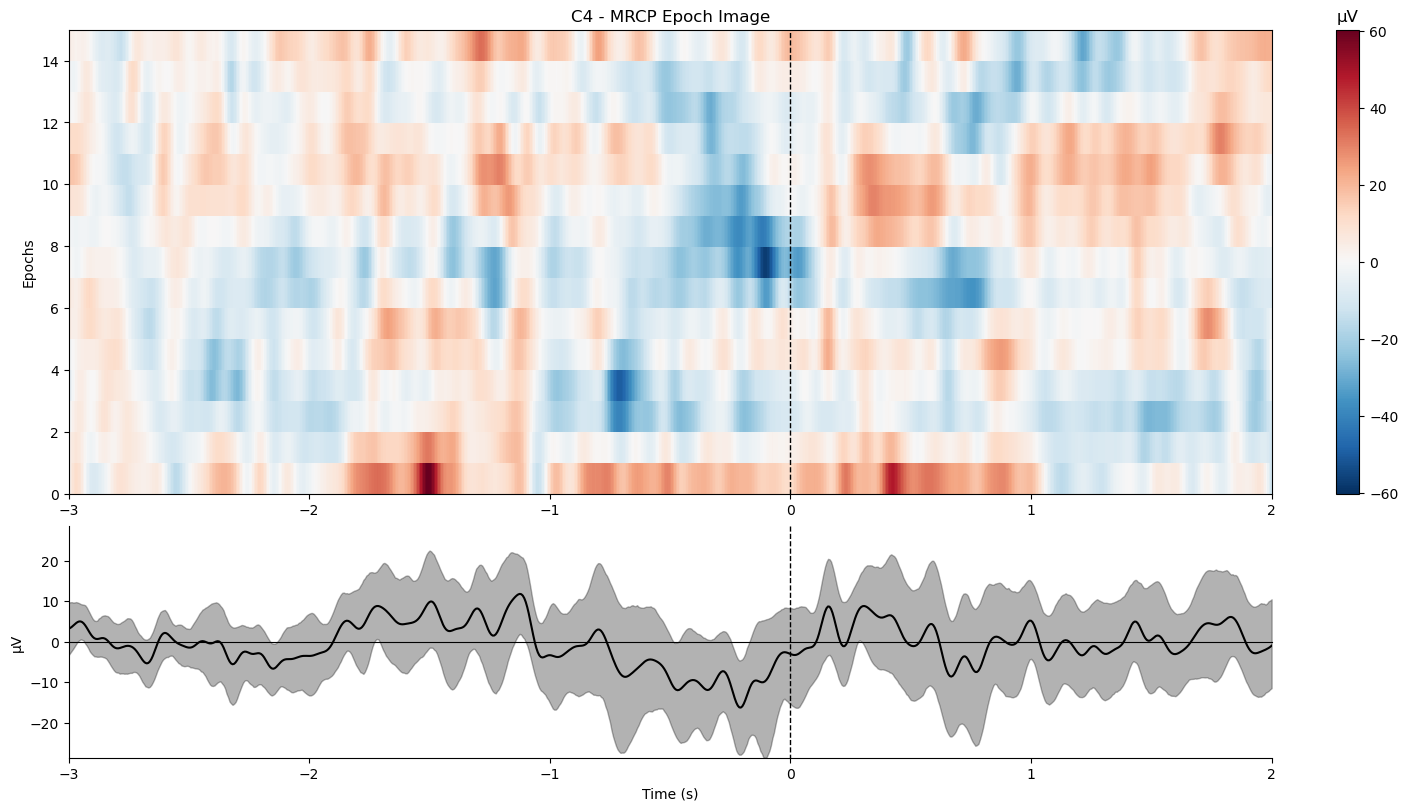

✓ Epoch image plots created

MRCP FEATURE EXTRACTION

[EXTRACTING FEATURES]
Computing MRCP features for 15 epochs...
✓ Features extracted
  Total rows: 45
  Features per epoch: 3 (one per channel)

[SAMPLE FEATURES - First 10 rows]
----------------------------------------------------------------------
 epoch_idx  condition channel  early_bp_amp  late_bp_amp  late_bp_slope  peak_negativity  peak_latency  motor_potential
         0 right_fist      C3    -10.281659     4.657702      41.182019       -39.994375      -1.00000         0.636227
         0 right_fist      Cz     -0.117057     9.020882      37.678296       -38.582920      -1.00000        11.980161
         0 right_fist      C4     23.308797    26.687578     -36.801685        11.108997      -0.00625        25.534232
         1  left_fist      C3     -9.917279     4.429386      -2.008644       -30.036854      -0.68750       -11.885584
         1  left_fist      Cz      1.636148    11.398870     -37.104947       -20.306356      -0.

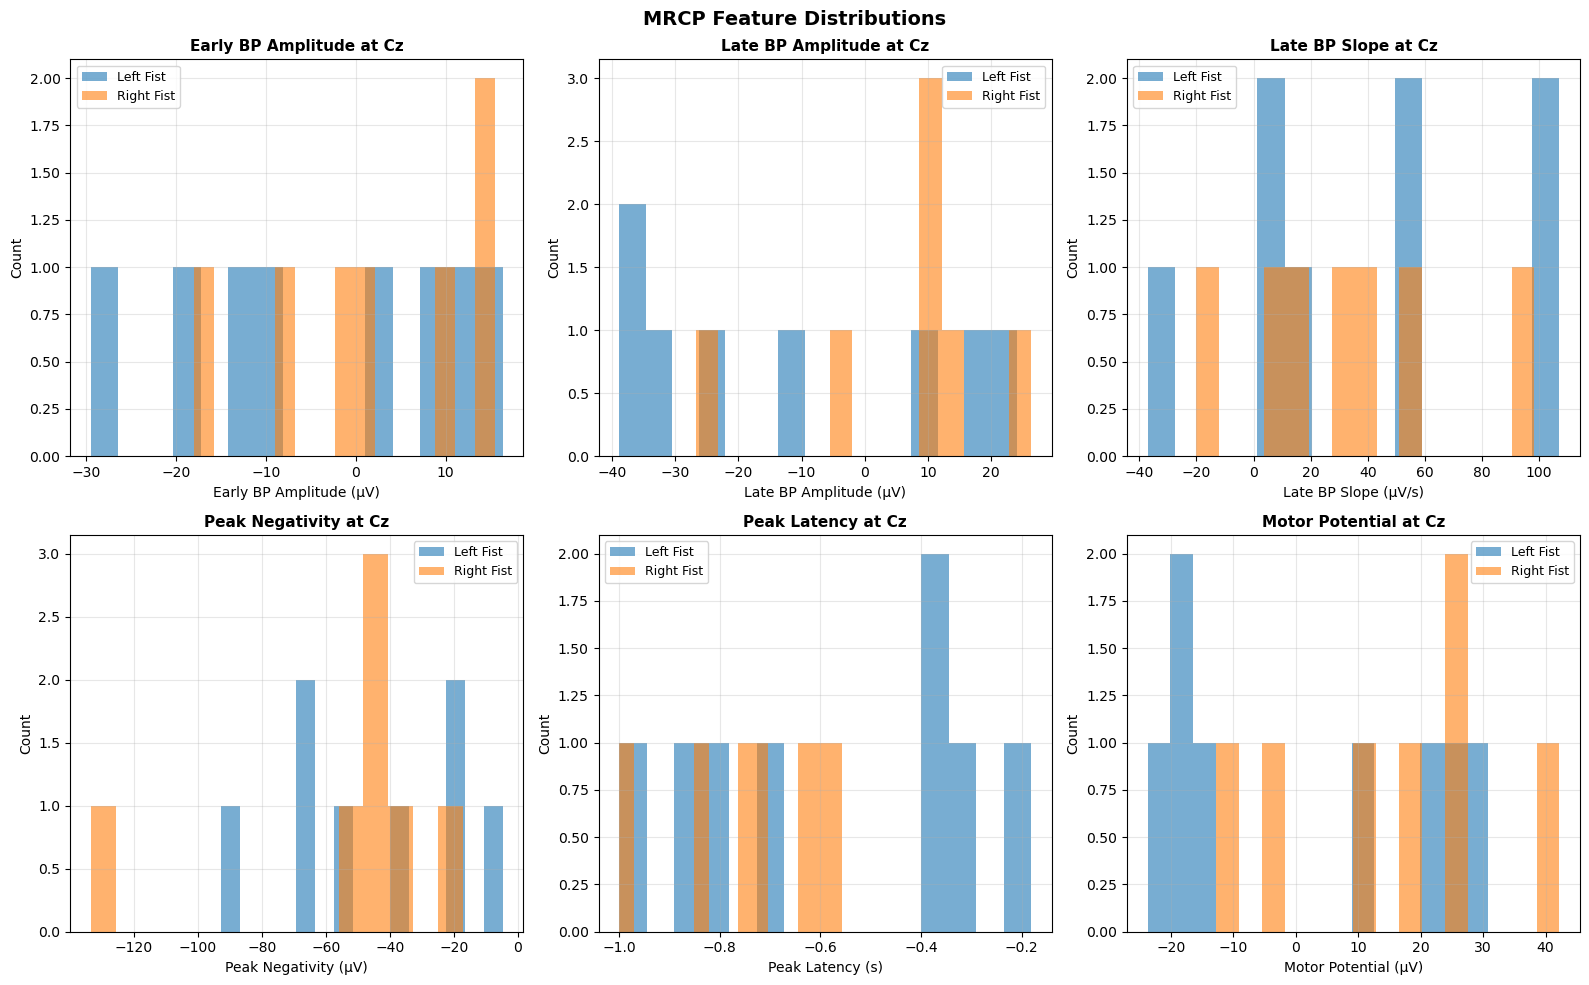

✓ Feature distributions plotted

STATISTICAL COMPARISON: LEFT VS RIGHT FIST

T-tests comparing left vs right fist movements:
----------------------------------------------------------------------
Feature                   Channel  Left Mean    Right Mean   t-stat     p-value    Sig  
----------------------------------------------------------------------
Early BP Amplitude        C3            -5.07        -4.11      -0.10     0.9249   ns   
Late BP Amplitude         C3            -2.46         2.88      -0.53     0.6053   ns   
Late BP Slope             C3            38.54        20.98       0.65     0.5256   ns   
Peak Negativity           C3           -36.95       -41.01       0.29     0.7783   ns   
Peak Latency              C3            -0.51        -0.64       0.93     0.3682   ns   
Motor Potential           C3             7.48        -0.41       0.92     0.3765   ns   
Early BP Amplitude        Cz            -4.02         1.65      -0.76     0.4622   ns   
Late BP Amplitude    

In [7]:
"""
MRCP VISUALIZATION AND ANALYSIS (FIXED)
========================================
Visualize Bereitschaftspotential (BP) and extract quantitative features
"""

print("\n" + "="*70)
print("MRCP WAVEFORM VISUALIZATION")
print("="*70)

# ============================================
# CHECK IF EPOCHS EXIST AND ARE NOT EMPTY
# ============================================
print("\n[CHECKING EPOCH AVAILABILITY]")
print("-"*70)

if len(epochs_mrcp) == 0:
    print("✗ ERROR: No epochs available!")
    print("\nPossible reasons:")
    print("  1. All epochs were rejected due to artifacts (>150 µV threshold)")
    print("  2. No movement events (T1/T2) found in the data")
    print("  3. Preprocessing issues")
    
    print("\n[DIAGNOSTIC INFORMATION]")
    print(f"  Total events in data: {len(events)}")
    print(f"  Movement events expected: {n_left + n_right}")
    
    # Check drop log
    print("\n[EPOCH DROP LOG]")
    drop_log = epochs_mrcp.drop_log
    n_dropped = sum([1 for log in drop_log if len(log) > 0])
    print(f"  Total epochs attempted: {len(drop_log)}")
    print(f"  Epochs dropped: {n_dropped}")
    
    if n_dropped > 0:
        print(f"\n  Reasons for dropping (first 10):")
        for i, log in enumerate(drop_log[:10]):
            if len(log) > 0:
                print(f"    Epoch {i}: {log}")
    
    print("\n[SUGGESTIONS]")
    print("  1. Try relaxing the rejection threshold:")
    print("     reject=dict(eeg=200e-6) instead of 150e-6")
    print("  2. Check if movement events (T1, T2) exist in raw.annotations")
    print("  3. Verify the event_id mapping is correct")
    print("  4. Try without rejection: reject=None")
    
    # Stop execution
    raise RuntimeError("Cannot proceed with empty epochs. Please check diagnostics above.")

else:
    print(f"✓ Epochs available: {len(epochs_mrcp)} total")
    print(f"  Left fist:  {len(epochs_mrcp['left_fist'])}")
    print(f"  Right fist: {len(epochs_mrcp['right_fist'])}")

# ============================================
# COMPUTE AVERAGED EVOKED RESPONSES
# ============================================
print("\n[COMPUTING AVERAGED MRCP WAVEFORMS]")
print("-"*70)

# Average across all movement trials
evoked_all = epochs_mrcp.average()
evoked_left = epochs_mrcp['left_fist'].average()
evoked_right = epochs_mrcp['right_fist'].average()

print(f"✓ Evoked responses computed")
print(f"  All movements:   {len(epochs_mrcp)} trials averaged")
print(f"  Left fist:       {len(epochs_mrcp['left_fist'])} trials averaged")
print(f"  Right fist:      {len(epochs_mrcp['right_fist'])} trials averaged")

# ============================================
# PLOT 1: MRCP AT MOTOR CHANNELS (ALL MOVEMENTS)
# ============================================
print("\n[PLOT 1: MRCP WAVEFORMS AT C3/CZ/C4]")

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

times = evoked_all.times
colors_ch = {'C3': 'blue', 'Cz': 'black', 'C4': 'red'}

for idx, ch_name in enumerate(available_channels):
    ax = axes[idx]
    
    # Get channel data
    ch_idx = evoked_all.ch_names.index(ch_name)
    data_uv = evoked_all.data[ch_idx, :] * 1e6  # Convert to µV
    
    # Plot MRCP waveform
    ax.plot(times, data_uv, linewidth=2.5, color=colors_ch.get(ch_name, 'black'),
           label=f'{ch_name}')
    
    # Add movement onset line
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Movement Onset')
    ax.axhline(0, color='gray', linestyle=':', linewidth=1)
    
    # Shade MRCP time windows
    ax.axvspan(-2.0, -0.5, alpha=0.1, color='green', label='Early BP')
    ax.axvspan(-0.5, 0, alpha=0.15, color='orange', label='Late BP')
    ax.axvspan(0, 0.5, alpha=0.1, color='purple', label='Motor Potential')
    
    # Labels
    ax.set_ylabel(f'{ch_name}\nAmplitude (µV)', fontsize=11, fontweight='bold')
    ax.set_title(f'MRCP at {ch_name} - All Movements (n={len(epochs_mrcp)})', 
                fontsize=12, fontweight='bold')
    ax.legend(loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # Add text annotations
    ax.text(-1.25, ax.get_ylim()[1]*0.9, 'Early BP\n(bilateral)', 
           fontsize=9, ha='center', color='green', fontweight='bold')
    ax.text(-0.25, ax.get_ylim()[1]*0.9, 'Late BP\n(steep)', 
           fontsize=9, ha='center', color='orange', fontweight='bold')

axes[-1].set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
axes[-1].set_xlim([TMIN, TMAX])

plt.suptitle('Movement-Related Cortical Potential (MRCP) - Bereitschaftspotential', 
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ MRCP waveforms plotted")

# ============================================
# PLOT 2: LEFT VS RIGHT COMPARISON
# ============================================
print("\n[PLOT 2: LEFT VS RIGHT FIST COMPARISON]")

fig, axes = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

for idx, ch_name in enumerate(available_channels):
    ax = axes[idx]
    
    # Get channel data for each condition
    ch_idx = evoked_left.ch_names.index(ch_name)
    left_data = evoked_left.data[ch_idx, :] * 1e6
    right_data = evoked_right.data[ch_idx, :] * 1e6
    
    # Plot both conditions
    ax.plot(times, left_data, linewidth=2.5, color='blue', 
           label=f'Left Fist (n={len(epochs_mrcp["left_fist"])})', alpha=0.8)
    ax.plot(times, right_data, linewidth=2.5, color='red',
           label=f'Right Fist (n={len(epochs_mrcp["right_fist"])})', alpha=0.8)
    
    # Add movement onset line
    ax.axvline(0, color='black', linestyle='--', linewidth=2, label='Movement Onset')
    ax.axhline(0, color='gray', linestyle=':', linewidth=1)
    
    # Shade BP windows
    ax.axvspan(-2.0, -0.5, alpha=0.05, color='green')
    ax.axvspan(-0.5, 0, alpha=0.1, color='orange')
    
    # Labels
    ax.set_ylabel(f'{ch_name}\nAmplitude (µV)', fontsize=11, fontweight='bold')
    ax.set_title(f'{ch_name}: Left vs Right Fist Movement', 
                fontsize=12, fontweight='bold')
    ax.legend(loc='upper left', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    # Lateralization notes
    if ch_name == 'C3':
        ax.text(0.02, 0.98, 'Left hemisphere\n(contralateral to RIGHT hand)', 
               transform=ax.transAxes, fontsize=9, va='top',
               bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.7))
    elif ch_name == 'C4':
        ax.text(0.02, 0.98, 'Right hemisphere\n(contralateral to LEFT hand)', 
               transform=ax.transAxes, fontsize=9, va='top',
               bbox=dict(boxstyle='round', facecolor='lightcyan', alpha=0.7))
    else:
        ax.text(0.02, 0.98, 'Midline\n(bilateral)', 
               transform=ax.transAxes, fontsize=9, va='top',
               bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.7))

axes[-1].set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
axes[-1].set_xlim([TMIN, TMAX])

plt.suptitle('MRCP Lateralization: Left vs Right Fist Movements', 
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Left vs Right comparison plotted")

# ============================================
# PLOT 3: TOPOGRAPHIC MAPS AT KEY TIME POINTS
# ============================================
print("\n[PLOT 3: TOPOGRAPHIC MAPS]")

# Time points to visualize
timepoints = [-2.0, -1.0, -0.5, -0.2, 0.0, 0.2, 0.5, 1.0]

fig = evoked_all.plot_topomap(times=timepoints, ch_type='eeg', 
                               colorbar=True, size=3)
plt.show()

print("✓ Topographic maps plotted")

# ============================================
# PLOT 4: IMAGE PLOT (ALL EPOCHS) - FIXED
# ============================================
print("\n[PLOT 4: EPOCH IMAGE PLOTS]")

# Create individual plots for each channel (cleaner visualization)
for ch_name in available_channels:
    print(f"  Creating epoch image for {ch_name}...")
    
    fig = epochs_mrcp.plot_image(
        picks=[ch_name], 
        combine='mean',
        evoked=True,
        colorbar=True,
        sigma=1.0,
        title=f'{ch_name} - MRCP Epoch Image',
        show=False
    )
    plt.show()

print("✓ Epoch image plots created")

# ============================================
# QUANTITATIVE MRCP FEATURE EXTRACTION
# ============================================
print("\n" + "="*70)
print("MRCP FEATURE EXTRACTION")
print("="*70)

def extract_mrcp_features(epochs, channels):
    """
    Extract quantitative MRCP features from epochs.
    
    Features:
    1. Early BP amplitude (-2 to -1 s): Mean amplitude
    2. Late BP amplitude (-0.5 to 0 s): Mean amplitude
    3. Late BP slope (-0.5 to 0 s): Linear slope
    4. Peak negativity (-1 to 0 s): Maximum negative amplitude
    5. Peak latency: Time of peak negativity
    6. Motor potential (0 to 0.3 s): Mean amplitude
    """
    
    features_list = []
    times = epochs.times
    
    # Define time windows
    early_bp_mask = (times >= -2.0) & (times <= -1.0)
    late_bp_mask = (times >= -0.5) & (times <= 0.0)
    peak_mask = (times >= -1.0) & (times <= 0.0)
    mp_mask = (times >= 0.0) & (times <= 0.3)
    
    for epoch_idx in range(len(epochs)):
        # Get event type
        event_id = epochs.events[epoch_idx, 2]
        if event_id == movement_event_id['left_fist']:
            condition = 'left_fist'
        elif event_id == movement_event_id['right_fist']:
            condition = 'right_fist'
        else:
            condition = 'unknown'
        
        for ch_name in channels:
            if ch_name not in epochs.ch_names:
                continue
                
            ch_idx = epochs.ch_names.index(ch_name)
            data = epochs.get_data()[epoch_idx, ch_idx, :] * 1e6  # µV
            
            # Feature 1: Early BP amplitude
            early_bp_amp = np.mean(data[early_bp_mask])
            
            # Feature 2: Late BP amplitude
            late_bp_amp = np.mean(data[late_bp_mask])
            
            # Feature 3: Late BP slope (linear regression)
            late_times = times[late_bp_mask]
            late_data = data[late_bp_mask]
            if len(late_times) > 1:
                slope, intercept = np.polyfit(late_times, late_data, 1)
            else:
                slope = np.nan
            
            # Feature 4 & 5: Peak negativity and latency
            peak_data = data[peak_mask]
            peak_idx = np.argmin(peak_data)
            peak_amp = peak_data[peak_idx]
            peak_lat = times[peak_mask][peak_idx]
            
            # Feature 6: Motor potential
            mp_amp = np.mean(data[mp_mask])
            
            # Store features
            features_list.append({
                'epoch_idx': epoch_idx,
                'condition': condition,
                'channel': ch_name,
                'early_bp_amp': early_bp_amp,
                'late_bp_amp': late_bp_amp,
                'late_bp_slope': slope,
                'peak_negativity': peak_amp,
                'peak_latency': peak_lat,
                'motor_potential': mp_amp
            })
    
    return pd.DataFrame(features_list)

# Extract features
print("\n[EXTRACTING FEATURES]")
print(f"Computing MRCP features for {len(epochs_mrcp)} epochs...")

features_df = extract_mrcp_features(epochs_mrcp, available_channels)

print(f"✓ Features extracted")
print(f"  Total rows: {len(features_df)}")
print(f"  Features per epoch: {len(available_channels)} (one per channel)")

# Display sample features
print(f"\n[SAMPLE FEATURES - First 10 rows]")
print("-"*70)
print(features_df.head(10).to_string(index=False))

# ============================================
# STATISTICAL SUMMARY
# ============================================
print("\n" + "="*70)
print("STATISTICAL SUMMARY")
print("="*70)

# Summary by condition and channel
summary_stats = features_df.groupby(['condition', 'channel']).agg({
    'early_bp_amp': ['mean', 'std'],
    'late_bp_amp': ['mean', 'std'],
    'late_bp_slope': ['mean', 'std'],
    'peak_negativity': ['mean', 'std'],
    'peak_latency': ['mean', 'std'],
    'motor_potential': ['mean', 'std']
}).round(2)

print("\n[MRCP FEATURES BY CONDITION AND CHANNEL]")
print(summary_stats)

# ============================================
# FEATURE VISUALIZATION
# ============================================
print("\n[VISUALIZING FEATURE DISTRIBUTIONS]")

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

feature_names = ['early_bp_amp', 'late_bp_amp', 'late_bp_slope', 
                'peak_negativity', 'peak_latency', 'motor_potential']
feature_labels = ['Early BP Amplitude', 'Late BP Amplitude', 'Late BP Slope',
                 'Peak Negativity', 'Peak Latency', 'Motor Potential']
feature_units = ['µV', 'µV', 'µV/s', 'µV', 's', 'µV']

for idx, (feat_name, feat_label, unit) in enumerate(zip(feature_names, feature_labels, feature_units)):
    ax = axes[idx]
    
    # Plot for Cz (or first available channel)
    plot_ch = 'Cz' if 'Cz' in available_channels else available_channels[0]
    
    for condition in ['left_fist', 'right_fist']:
        data = features_df[
            (features_df['condition'] == condition) & 
            (features_df['channel'] == plot_ch)
        ][feat_name]
        
        ax.hist(data, alpha=0.6, label=condition.replace('_', ' ').title(), bins=15)
    
    ax.set_xlabel(f'{feat_label} ({unit})', fontsize=10)
    ax.set_ylabel('Count', fontsize=10)
    ax.set_title(f'{feat_label} at {plot_ch}', fontsize=11, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('MRCP Feature Distributions', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("✓ Feature distributions plotted")

# ============================================
# STATISTICAL COMPARISON: LEFT VS RIGHT
# ============================================
print("\n" + "="*70)
print("STATISTICAL COMPARISON: LEFT VS RIGHT FIST")
print("="*70)

print("\nT-tests comparing left vs right fist movements:")
print("-"*70)
print(f"{'Feature':<25} {'Channel':<8} {'Left Mean':<12} {'Right Mean':<12} {'t-stat':<10} {'p-value':<10} {'Sig':<5}")
print("-"*70)

for ch in available_channels:
    for feat_name, feat_label in zip(feature_names, feature_labels):
        left_data = features_df[
            (features_df['condition'] == 'left_fist') & 
            (features_df['channel'] == ch)
        ][feat_name].dropna()
        
        right_data = features_df[
            (features_df['condition'] == 'right_fist') & 
            (features_df['channel'] == ch)
        ][feat_name].dropna()
        
        if len(left_data) > 0 and len(right_data) > 0:
            t_stat, p_val = ttest_ind(left_data, right_data)
            sig = '***' if p_val < 0.001 else '**' if p_val < 0.01 else '*' if p_val < 0.05 else 'ns'
            
            print(f"{feat_label:<25} {ch:<8} {left_data.mean():>10.2f}   {right_data.mean():>10.2f}   "
                  f"{t_stat:>8.2f}   {p_val:>8.4f}   {sig:<5}")

print("-"*70)
print("Significance: *** p<0.001, ** p<0.01, * p<0.05, ns = not significant")

# ============================================
# LATERALIZATION ANALYSIS
# ============================================
print("\n" + "="*70)
print("LATERALIZATION ANALYSIS")
print("="*70)

if 'C3' in available_channels and 'C4' in available_channels:
    print("\nExpected lateralization:")
    print("  • Left fist → stronger BP at C4 (contralateral)")
    print("  • Right fist → stronger BP at C3 (contralateral)")
    
    print("\n[LATE BP AMPLITUDE COMPARISON]")
    print("-"*70)
    
    # Left fist movement
    left_c3 = features_df[
        (features_df['condition'] == 'left_fist') & 
        (features_df['channel'] == 'C3')
    ]['late_bp_amp'].mean()
    
    left_c4 = features_df[
        (features_df['condition'] == 'left_fist') & 
        (features_df['channel'] == 'C4')
    ]['late_bp_amp'].mean()
    
    # Right fist movement
    right_c3 = features_df[
        (features_df['condition'] == 'right_fist') & 
        (features_df['channel'] == 'C3')
    ]['late_bp_amp'].mean()
    
    right_c4 = features_df[
        (features_df['condition'] == 'right_fist') & 
        (features_df['channel'] == 'C4')
    ]['late_bp_amp'].mean()
    
    print(f"\nLeft Fist Movement:")
    print(f"  C3 (ipsilateral):     {left_c3:>8.2f} µV")
    print(f"  C4 (contralateral):   {left_c4:>8.2f} µV")
    print(f"  Laterality index:     {left_c4 - left_c3:>8.2f} µV")
    
    print(f"\nRight Fist Movement:")
    print(f"  C3 (contralateral):   {right_c3:>8.2f} µV")
    print(f"  C4 (ipsilateral):     {right_c4:>8.2f} µV")
    print(f"  Laterality index:     {right_c3 - right_c4:>8.2f} µV")
    
    print("\nNote: More negative = stronger BP (motor preparation)")

# ============================================
# FINAL SUMMARY
# ============================================
print("\n" + "="*70)
print("MRCP ANALYSIS COMPLETE")
print("="*70)

print(f"\n[RESULTS SUMMARY]")
print(f"  Total trials analyzed:    {len(epochs_mrcp)}")
print(f"  Left fist trials:         {len(epochs_mrcp['left_fist'])}")
print(f"  Right fist trials:        {len(epochs_mrcp['right_fist'])}")
print(f"  Channels analyzed:        {available_channels}")
print(f"  Features extracted:       6 per trial-channel combination")
print(f"  Total feature rows:       {len(features_df)}")

print(f"\n[VISUALIZATIONS CREATED]")
print(f"  ✓ MRCP waveforms at C3/Cz/C4")
print(f"  ✓ Left vs Right comparison")
print(f"  ✓ Topographic maps")
print(f"  ✓ Epoch image plots")
print(f"  ✓ Feature distributions")

print(f"\n[QUANTITATIVE FEATURES]")
print(f"  ✓ Early BP amplitude (-2 to -1 s)")
print(f"  ✓ Late BP amplitude (-0.5 to 0 s)")
print(f"  ✓ Late BP slope (µV/s)")
print(f"  ✓ Peak negativity & latency")
print(f"  ✓ Motor potential (0 to 0.3 s)")

print(f"\n[STATISTICAL ANALYSIS]")
print(f"  ✓ Descriptive statistics by condition")
print(f"  ✓ T-tests (left vs right)")
print(f"  ✓ Lateralization analysis")

print("\n" + "="*70)

In [8]:
print("Channels available:", evoked_all.ch_names)
print("Data shape:", evoked_all.data.shape)
print("Times available:", times[:10])  # Check first 10 time points


Channels available: ['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FT8', 'T7', 'T8', 'T9', 'T10', 'TP7', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Iz']
Data shape: (64, 801)
Times available: [-3.      -2.99375 -2.9875  -2.98125 -2.975   -2.96875 -2.9625  -2.95625
 -2.95    -2.94375]


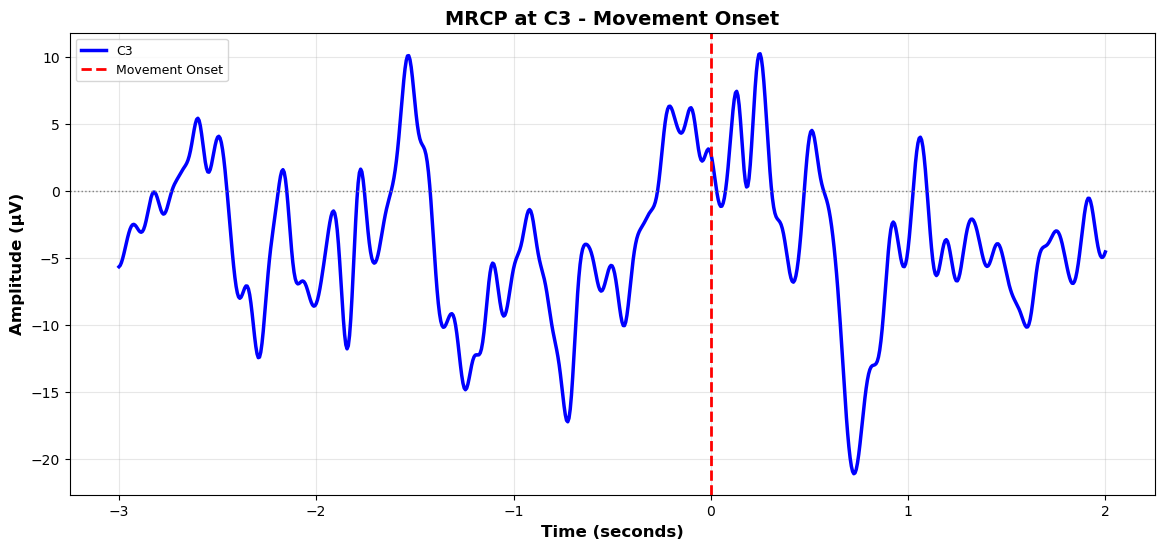

In [10]:
# Debugging with first channel
fig, ax = plt.subplots(figsize=(14, 6))

ch_idx = evoked_all.ch_names.index('C3')  # Try with C3 channel
data_uv = evoked_all.data[ch_idx, :] * 1e6  # Convert to µV

ax.plot(times, data_uv, linewidth=2.5, color='blue', label='C3')
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Movement Onset')
ax.axhline(0, color='gray', linestyle=':', linewidth=1)

ax.set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
ax.set_ylabel('Amplitude (µV)', fontsize=12, fontweight='bold')
ax.set_title('MRCP at C3 - Movement Onset', fontsize=14, fontweight='bold')

plt.legend(loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.show()



DEBUGGING: MRCP WAVEFORM VISUALIZATION

[CHECKING EPOCH AVAILABILITY]
----------------------------------------------------------------------
✓ Epochs available: 15 total
  Left fist:  8
  Right fist: 7

[CHECKING DATA SHAPE & TIMES]
----------------------------------------------------------------------
  Time range in evoked data: -3.0 to 2.0
  Total time points: 801
  Shape of evoked data (channels x time): (64, 801)

[CHECKING CHANNELS]
  Available channels: ['FC5', 'FC3', 'FC1', 'FCz', 'FC2', 'FC4', 'FC6', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4', 'C6', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6', 'Fp1', 'Fpz', 'Fp2', 'AF7', 'AF3', 'AFz', 'AF4', 'AF8', 'F7', 'F5', 'F3', 'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FT8', 'T7', 'T8', 'T9', 'T10', 'TP7', 'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO3', 'POz', 'PO4', 'PO8', 'O1', 'Oz', 'O2', 'Iz']
  ✓ Channel C3 found.
  ✓ Channel Cz found.
  ✓ Channel C4 found.

[CHECKING MOVEMENT EVENTS]
-----------------------

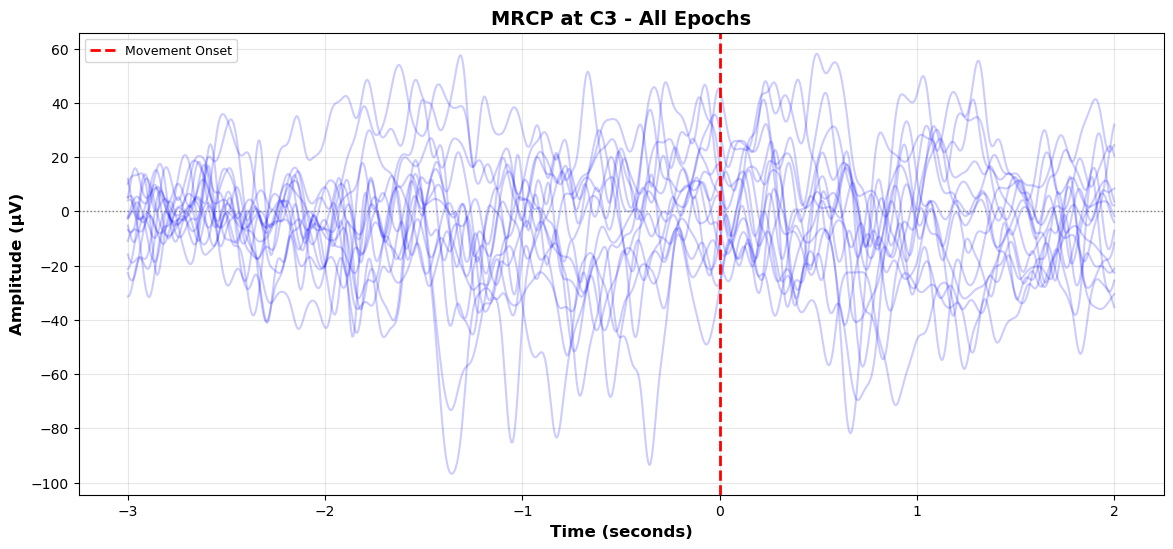


[DEBUGGING: PLOTTING ALL EPOCHS]
----------------------------------------------------------------------


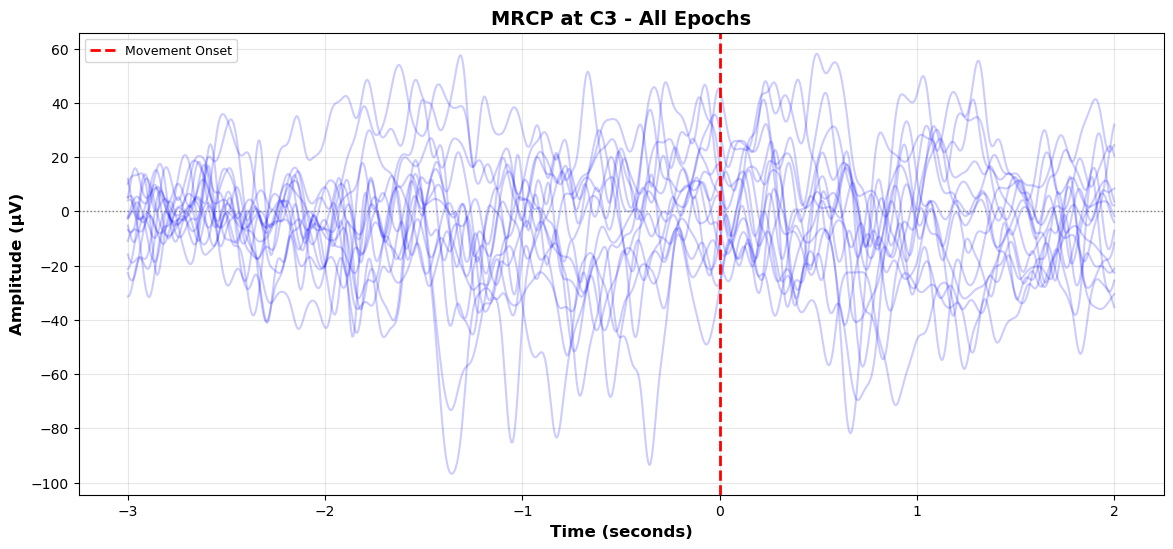


[FINAL CHECK: MOVEMENT EVENTS AND DATA MATCH]
----------------------------------------------------------------------
Event 0: 4.2 seconds, Event ID: 3
Event 1: 12.5 seconds, Event ID: 2
Event 2: 20.8 seconds, Event ID: 2
Event 3: 29.1 seconds, Event ID: 3
Event 4: 37.4 seconds, Event ID: 3
Event 5: 45.7 seconds, Event ID: 2
Event 6: 54.0 seconds, Event ID: 2
Event 7: 62.3 seconds, Event ID: 3
Event 8: 70.6 seconds, Event ID: 2
Event 9: 78.9 seconds, Event ID: 3
Event 10: 87.2 seconds, Event ID: 3
Event 11: 95.5 seconds, Event ID: 2
Event 12: 103.8 seconds, Event ID: 2
Event 13: 112.1 seconds, Event ID: 3
Event 14: 120.4 seconds, Event ID: 2


In [16]:
# ============================================
# DEBUGGING: CHECK DATA AND PLOT SETTINGS
# ============================================

print("\n" + "="*70)
print("DEBUGGING: MRCP WAVEFORM VISUALIZATION")
print("="*70)

# ============================================
# 1. CHECK IF EPOCHS EXIST AND ARE NOT EMPTY
# ============================================
print("\n[CHECKING EPOCH AVAILABILITY]")
print("-"*70)

# Check if epochs_mrcp contains any epochs
if len(epochs_mrcp) == 0:
    print("✗ ERROR: No epochs available!")
    print("\nPossible reasons:")
    print("  1. All epochs were rejected due to artifacts (>150 µV threshold)")
    print("  2. No movement events (T1/T2) found in the data")
    print("  3. Preprocessing issues")
    
    # Check drop log
    print("\n[EPOCH DROP LOG]")
    drop_log = epochs_mrcp.drop_log
    n_dropped = sum([1 for log in drop_log if len(log) > 0])
    print(f"  Total epochs attempted: {len(drop_log)}")
    print(f"  Epochs dropped: {n_dropped}")
    
    if n_dropped > 0:
        print(f"\n  Reasons for dropping (first 10):")
        for i, log in enumerate(drop_log[:10]):
            if len(log) > 0:
                print(f"    Epoch {i}: {log}")
    
    raise RuntimeError("Cannot proceed with empty epochs. Please check diagnostics above.")

else:
    print(f"✓ Epochs available: {len(epochs_mrcp)} total")
    print(f"  Left fist:  {len(epochs_mrcp['left_fist'])}")
    print(f"  Right fist: {len(epochs_mrcp['right_fist'])}")

# ============================================
# 2. CHECK THE TIMES AND DATA SHAPE
# ============================================
print("\n[CHECKING DATA SHAPE & TIMES]")
print("-"*70)

# Check the times available in the evoked data
times = evoked_all.times
print(f"  Time range in evoked data: {times[0]} to {times[-1]}")
print(f"  Total time points: {len(times)}")

# Check the shape of the evoked data
print(f"  Shape of evoked data (channels x time): {evoked_all.data.shape}")

# Check if available channels match what's in the data
print("\n[CHECKING CHANNELS]")
available_channels = ['C3', 'Cz', 'C4']  # Set your channels here
print(f"  Available channels: {evoked_all.ch_names}")
for ch_name in available_channels:
    if ch_name not in evoked_all.ch_names:
        print(f"  ✗ Channel {ch_name} not found!")
    else:
        print(f"  ✓ Channel {ch_name} found.")

# ============================================
# 3. CHECK IF THE MOVEMENT EVENTS (T1/T2) ARE PRESENT
# ============================================
print("\n[CHECKING MOVEMENT EVENTS]")
print("-"*70)

# Check if the expected movement events are present
events = epochs_mrcp.events
print(f"  Total events in the data: {len(events)}")
print(f"  Movement event IDs: {epochs_mrcp.event_id}")

# Check for the presence of movement events (T1 and T2)
movement_event_ids = ['left_fist', 'right_fist']
for event_id in movement_event_ids:
    if event_id not in epochs_mrcp.event_id:
        print(f"  ✗ Movement event {event_id} not found in event_id!")
    else:
        print(f"  ✓ Movement event {event_id} found in event_id.")

# ============================================
# ============================================
# 4. CHECK EPOCH DATA FOR CHANNELS AND TIME POINTS
# ============================================
print("\n[CHECKING EPOCH DATA FOR CHANNELS AND TIME POINTS]")
print("-"*70)

# Get data for a sample epoch (the first one)
sample_epoch_data = epochs_mrcp.get_data()[0]  # Get the first epoch's data (channels x time points)
print(f"  Shape of sample epoch data (channels x time points): {sample_epoch_data.shape}")

# Inspect the first few samples of the data
print(f"  First few samples of data (channel C3): {sample_epoch_data[epochs_mrcp.ch_names.index('C3'), :5]}")

# ============================================
# 5. PLOT A SINGLE CHANNEL TO VISUALIZE THE DATA
# ============================================
print("\n[DEBUGGING: PLOTTING SAMPLE CHANNEL]")
print("-"*70)

# Let's plot the first channel (C3) of the first epoch to check the data visually
fig, ax = plt.subplots(figsize=(14, 6))
ch_name = 'C3'

# Get data for all epochs (3D array: epochs x channels x time points)
data_uv = epochs_mrcp.get_data()[:, epochs_mrcp.ch_names.index(ch_name), :] * 1e6  # Convert to µV

# Plot the MRCP waveform for all epochs with transparency
for epoch_data in data_uv:
    ax.plot(times, epoch_data, color='blue', alpha=0.2)

# Add movement onset line
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Movement Onset')
ax.axhline(0, color='gray', linestyle=':', linewidth=1)

ax.set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
ax.set_ylabel('Amplitude (µV)', fontsize=12, fontweight='bold')
ax.set_title(f'MRCP at {ch_name} - All Epochs', fontsize=14, fontweight='bold')

plt.legend(loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.show()

# ============================================
# 6. PLOT ALL EPOCHS WITH TRANSPARENCY TO SEE MULTIPLE TRIALS
# ============================================
print("\n[DEBUGGING: PLOTTING ALL EPOCHS]")
print("-"*70)

fig, ax = plt.subplots(figsize=(14, 6))

# Get all epochs data for a particular channel (e.g., 'C3')
ch_name = 'C3'
ch_idx = epochs_mrcp.ch_names.index(ch_name)

# Get all the data for the channel across all epochs (shape: [n_epochs, n_times])
data_uv = epochs_mrcp.get_data()[:, ch_idx, :] * 1e6  # Convert to µV

# Plot each epoch individually (with transparency)
for epoch_data in data_uv:
    ax.plot(times, epoch_data, color='blue', alpha=0.2)  # Add transparency for multiple trials

# Add movement onset line
ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Movement Onset')
ax.axhline(0, color='gray', linestyle=':', linewidth=1)

ax.set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
ax.set_ylabel('Amplitude (µV)', fontsize=12, fontweight='bold')
ax.set_title(f'MRCP at {ch_name} - All Epochs', fontsize=14, fontweight='bold')

plt.legend(loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.show()

# ============================================
# FINAL CHECK: IF MOVEMENT EVENTS AND DATA MATCH
# ============================================
print("\n[FINAL CHECK: MOVEMENT EVENTS AND DATA MATCH]")
print("-"*70)

# Check that movement events correspond to valid data indices
for idx, event in enumerate(epochs_mrcp.events):
    event_time = event[0] / epochs_mrcp.info['sfreq']  # Convert to seconds
    print(f"Event {idx}: {event_time} seconds, Event ID: {event[2]}")
